In [ ]:
import sys
import os
import socket

from pyspark.sql import SparkSession

spark_home = "/apache/spark3.1"
bx_pex_file = "bx_pex_env_5_9_1.pex"
os.environ["SPARK_HOME"] = spark_home
os.environ["PYSPARK_PYTHON"] = f"./{bx_pex_file}"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/share/anaconda3/python3.7/bin/python"
sys.path.append(f"{spark_home}/python/lib/py4j-0.10.9-src.zip")
sys.path.append(f"{spark_home}/python")

spark = SparkSession \
    .builder \
    .appName("click_propensity_estimator_" + os.environ["KRYLOV_PRINCIPAL"]) \
    .master("yarn") \
    .config("spark.driver.host", socket.gethostbyname(socket.gethostname())) \
    .config("spark.driver.port", "30202") \
    .config("spark.yarn.executor.memoryOverhead", "1024") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "25g") \
    .config("spark.executor.memory", "25g") \
    .config("spark.rdd.compress", True) \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "300s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.dynamicAllocation.minExecutors", 0) \
    .config("spark.dynamicAllocation.initialExecutors", 10) \
    .config("spark.dynamicAllocation.maxExecutors", 50) \
    .config("spark.yarn.queue", "hddq-exprce-perso-high-mem") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.driver.extraJavaOptions", '-Dhttp.proxyHost=httpproxy.vip.ebay.com -Dhttp.proxyPort=80 -Dhttps.proxyHost=httpproxy.vip.ebay.com -Dhttps.proxyPort=80') \
    .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.1.1") \
    .config("spark.files", f"viewfs://apollo-rno/user/b_perso/pex_environments/{bx_pex_file}") \
    .enableHiveSupport() \
    .getOrCreate()

spark


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/apache/releases/hadoop-2.7.3.2.6.4.2.0.38/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/apache/releases/hbase-1.1.2.2.6.4.1.0.3/lib/slf4j-log4j12-1.7.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
23/01/16 10:02:24 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.


:: loading settings :: url = jar:file:/apache/releases/spark-3.1.1.0.9.0-bin-ebay/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/olivyatan/.ivy2/cache
The jars for the packages stored in: /home/olivyatan/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-567384b3-118c-4950-900d-1b54b14ea1ea;1.0
	confs: [default]


In [2]:
import sys
import os
import socket
import datetime


from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.avro.functions import from_avro
from pyspark.sql.window import Window

import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.avro.functions import from_avro
from pyspark.sql.window import Window

import datetime
import pandas as pd
import numpy as np

In [4]:
sparkHome = "/apache/spark3.1"
bxPexFile = "bx_pex_env_5_9_1.pex"
os.environ["SPARK_HOME"] = sparkHome
os.environ["PYSPARK_PYTHON"] = f"./{bxPexFile}"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/share/anaconda3/python3.7/bin/python"
sys.path.append(f"{sparkHome}/python/lib/py4j-0.10.9-src.zip")
sys.path.append(f"{sparkHome}/python")

host_ip = socket.gethostbyname(socket.gethostname())

spark = SparkSession \
    .builder \
    .appName("click_propensity_estimator_" + os.environ["KRYLOV_PRINCIPAL"]) \
    .master("yarn") \
    .config("spark.driver.maxResultSize", "15g")\
    .config("spark.driver.host", host_ip) \
    .config("spark.driver.port", "30202") \
    .config("spark.yarn.executor.memoryOverhead", "32g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "25g") \
    .config("spark.executor.memory", "25g") \
    .config("spark.rdd.compress", True) \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "300s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.dynamicAllocation.minExecutors", 0) \
    .config("spark.dynamicAllocation.initialExecutors", 100) \
    .config("spark.dynamicAllocation.maxExecutors", 10000) \
    .config("spark.sql.shuffle.partitions", 512)\
    .config("spark.kryoserializer.buffer.max", "1g")\
    .config("spark.rpc.message.maxSize", 1024)\
    .config("spark.yarn.queue", "hddq-exprce-perso-high-mem") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.files", f"viewfs://apollo-rno/user/b_perso/pex_environments/{bxPexFile}") \
    .enableHiveSupport() \
    .getOrCreate()

spark

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/apache/releases/hadoop-2.7.3.2.6.4.2.0.38/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/apache/releases/hbase-1.1.2.2.6.4.1.0.3/lib/slf4j-log4j12-1.7.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
23/01/22 13:59:06 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/22 13:59:06 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.


2023-01-22T13:59:07.207+0000: [Full GC (Metadata GC Threshold) 2023-01-22T13:59:07.207+0000: [Tenured: 0K->16985K(1398144K), 0.0957485 secs] 234905K->16985K(2027264K), [Metaspace: 20212K->20212K(1067008K)], 0.0958198 secs] [Times: user=0.09 sys=0.01, real=0.09 secs] 


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/22 13:59:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/22 13:59:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
23/01/22 13:59:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.


2023-01-22T13:59:08.922+0000: [Full GC (Metadata GC Threshold) 2023-01-22T13:59:08.922+0000: [Tenured: 16985K->30516K(1398144K), 0.1181640 secs] 408735K->30516K(2027392K), [Metaspace: 33997K->33997K(1079296K)], 0.1182163 secs] [Times: user=0.12 sys=0.01, real=0.12 secs] 
2023-01-22T13:59:22.883+0000: [Full GC (Metadata GC Threshold) 2023-01-22T13:59:22.883+0000: [Tenured: 30516K->49873K(1398144K), 0.2225499 secs] 422609K->49873K(2027392K), [Metaspace: 56247K->56247K(1101824K)], 0.2226352 secs] [Times: user=0.19 sys=0.04, real=0.22 secs] 


23/01/22 13:59:24 WARN HiveConf: DEPRECATED: hive.metastore.ds.retry.* no longer has any effect.  Use hive.hmshandler.retry.* instead
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.metastore.local does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.enforce.sorting does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.server2.proxyuser.hue.groups does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.server2.proxyuser.hue.hosts does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.metastore.ds.retry.interval does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.enforce.bucketing does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.metastore.ds.retry.attempts does not exist
23/01/22 13:59:24 WARN HiveConf: HiveConf of name hive.server2.enable.impersonation does not exist
23/01/22 13:59:25 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated a

2023-01-22T13:59:27.206+0000: [GC (Allocation Failure) 2023-01-22T13:59:27.206+0000: [DefNew
Desired survivor size 35782656 bytes, new threshold 15 (max 15)
- age   1:   29528032 bytes,   29528032 total
: 559360K->28835K(629248K), 0.0641975 secs] 609233K->78709K(2027392K), 0.0642647 secs] [Times: user=0.05 sys=0.02, real=0.07 secs] 


23/01/22 13:59:46 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


2023-01-22T13:59:52.997+0000: [Full GC (Metadata GC Threshold) 2023-01-22T13:59:52.997+0000: [Tenured: 49873K->42475K(1398144K), 0.2292035 secs] 549579K->42475K(2027392K), [Metaspace: 93268K->93268K(1134592K)], 0.2293014 secs] [Times: user=0.21 sys=0.02, real=0.23 secs] 


2023-01-22T14:29:46.281+0000: [Full GC (System.gc()) 2023-01-22T14:29:46.281+0000: [Tenured: 42475K->47490K(1398144K), 0.3163858 secs] 458151K->47490K(2027392K), [Metaspace: 99385K->99385K(1140736K)], 0.3165204 secs] [Times: user=0.24 sys=0.07, real=0.31 secs] 
2023-01-22T14:59:46.280+0000: [Full GC (System.gc()) 2023-01-22T14:59:46.280+0000: [Tenured: 47490K->47691K(1398144K), 0.2302273 secs] 294267K->47691K(2027392K), [Metaspace: 99481K->99481K(1140736K)], 0.2303393 secs] [Times: user=0.20 sys=0.04, real=0.23 secs] 
2023-01-22T15:29:46.280+0000: [Full GC (System.gc()) 2023-01-22T15:29:46.281+0000: [Tenured: 47691K->48366K(1398144K), 0.2432754 secs] 292960K->48366K(2027392K), [Metaspace: 99561K->99561K(1140736K)], 0.2433754 secs] [Times: user=0.19 sys=0.05, real=0.24 secs] 
2023-01-22T15:59:46.280+0000: [Full GC (System.gc()) 2023-01-22T15:59:46.280+0000: [Tenured: 48366K->33125K(1398144K), 0.2445643 secs] 293025K->33125K(2027392K), [Metaspace: 99647K->99647K(1140736K)], 0.2446502 sec

23/01/22 16:08:36 ERROR YarnClientSchedulerBackend: YARN application has exited unexpectedly with state KILLED! Check the YARN application logs for more details.
23/01/22 16:08:36 ERROR YarnClientSchedulerBackend: Diagnostics message: Application killed by user.
23/01/22 16:08:37 WARN TransportChannelHandler: Exception in connection from /10.216.170.75:40092
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1133)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractN

# click-propensity

In [4]:
schema = T.StructType(
    [
        T.StructField('siteId', T.IntegerType(), True),
        T.StructField('experience', T.StringType(), True),
        T.StructField('placementId', T.IntegerType(), True),
        T.StructField('displayRank', T.IntegerType(), True),
        T.StructField('clickPropensity', T.FloatType(), True),
#         T.StructField('purchasePropensity', T.FloatType(), True),
        T.StructField('n', T.IntegerType(), True)
    ]
)


path = "viewfs://apollo-rno/apps/b_perso/hp/click_propensity/experience/mad_cdl/position_bias.tsv"


clickCount = spark.read.option("header", True).schema(schema).option("delimiter", "\t").csv(path)


In [5]:
pdf = clickCount.toPandas()
pdf

23/01/16 10:09:14 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/16 10:09:29 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/16 10:09:44 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/16 10:09:59 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/16 10:10:14 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/01/16 10:10:29 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registere

,siteId,experience,placementId,displayRank,clickPropensity,n
0,0,Apps: Android,101251,1,0.005221,602517
1,0,Apps: Android,101251,2,0.004612,38380
2,0,Apps: Android,101251,3,0.001961,19378
3,0,Apps: Android,101251,4,0.002125,19295
4,0,Apps: Android,101251,5,0.001573,17800
...,...,...,...,...,...,...
3781,216,Browser: mWeb,101286,11,0.000000,1
3782,216,Browser: mWeb,101286,12,0.000000,1
3783,216,Browser: mWeb,101286,13,0.000000,1
3784,216,Browser: mWeb,101286,14,0.000000,2


In [6]:

w = Window.partitionBy("siteId", "experience", "placementId").orderBy([F.col("displayRank").asc()])

clickCount1 = clickCount \
    .withColumn("bias1", F.first("clickPropensity", True).over(w)) \
    .withColumn("biasK", F.col("clickPropensity")) \
    .withColumn("propensity_pretrainer", F.col("biasK") / F.col("bias1")) \
    .withColumn("propensity_impression_weights", 1 / F.col("propensity_pretrainer"))



In [7]:
pdf1 = clickCount1.toPandas()

2023-01-16T10:13:22.261+0000: [GC (Allocation Failure) 2023-01-16T10:13:22.261+0000: [DefNew
Desired survivor size 35782656 bytes, new threshold 15 (max 15)
- age   1:   33104472 bytes,   33104472 total
: 559360K->32328K(629248K), 0.0642483 secs] 601458K->74426K(2027392K), 0.0643250 secs] [Times: user=0.04 sys=0.03, real=0.06 secs] 


In [8]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',5)

In [12]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [14]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',40)

In [9]:
pdf1

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
0,77,Browser: mWeb,101280,1,0.0,434,0.0,0.0,NaN,NaN
1,77,Browser: mWeb,101280,2,0.0,15,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3784,2,Browser: Core site,101287,4,0.0,1,0.0,0.0,NaN,NaN
3785,2,Browser: Core site,101287,5,0.0,1,0.0,0.0,NaN,NaN


In [59]:
experience

['Apps: Android',
 'Apps: Other',
 'Apps: iPad',
 'Apps: iPhone',
 'Browser: Core site',
 'Browser: mWeb']

In [58]:
pdf1[(pdf1["placementId"]==101251 ) & (pdf1["siteId"]==0) & (pdf1["experience"]=='Apps: Other') ].sort_values(by='displayRank')

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
2796,0,Apps: Other,101251,1,0.0,71,0.0,0.0,NaN,NaN
2797,0,Apps: Other,101251,2,0.0,4,0.0,0.0,NaN,NaN
2798,0,Apps: Other,101251,3,0.0,1,0.0,0.0,NaN,NaN
2799,0,Apps: Other,101251,4,0.0,2,0.0,0.0,NaN,NaN
2800,0,Apps: Other,101251,5,0.0,2,0.0,0.0,NaN,NaN
2801,0,Apps: Other,101251,6,0.0,3,0.0,0.0,NaN,NaN
2802,0,Apps: Other,101251,7,0.0,4,0.0,0.0,NaN,NaN
2803,0,Apps: Other,101251,8,0.0,3,0.0,0.0,NaN,NaN
2804,0,Apps: Other,101251,9,0.0,3,0.0,0.0,NaN,NaN
2805,0,Apps: Other,101251,10,0.0,2,0.0,0.0,NaN,NaN


In [42]:
pdf1[(pdf1["placementId"]==101251 ) & (pdf1["siteId"]==0) & (pdf1["experience"]==experience[0]) ].sort_values(by='displayRank')

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
1283,0,Apps: Android,101251,1,0.005221,602517,0.005221,0.005221,1.000000,1.000000
1284,0,Apps: Android,101251,2,0.004612,38380,0.005221,0.004612,0.883240,1.132195
1285,0,Apps: Android,101251,3,0.001961,19378,0.005221,0.001961,0.375565,2.662654
1286,0,Apps: Android,101251,4,0.002125,19295,0.005221,0.002125,0.406958,2.457256
1287,0,Apps: Android,101251,5,0.001573,17800,0.005221,0.001573,0.301265,3.319337
1288,0,Apps: Android,101251,6,0.001934,16543,0.005221,0.001934,0.370464,2.699316
1289,0,Apps: Android,101251,7,0.001571,15273,0.005221,0.001571,0.300952,3.322787
1290,0,Apps: Android,101251,8,0.000758,14508,0.005221,0.000758,0.145210,6.886590
1291,0,Apps: Android,101251,9,0.001107,13545,0.005221,0.001107,0.212091,4.714951
1292,0,Apps: Android,101251,10,0.002323,11623,0.005221,0.002323,0.444894,2.247729


In [60]:
pdf1[(pdf1["placementId"]==101259 ) & (pdf1["siteId"]==0) & (pdf1["experience"]== 'Browser: Core site') ].sort_values(by='displayRank')

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
3122,0,Browser: Core site,101259,1,0.001176,535521,0.001176,0.001176,1.000000,1.000000
3123,0,Browser: Core site,101259,2,0.001150,6956,0.001176,0.001150,0.977612,1.022901
3124,0,Browser: Core site,101259,3,0.001023,6841,0.001176,0.001023,0.869790,1.149703
3125,0,Browser: Core site,101259,4,0.001627,6762,0.001176,0.001627,1.382781,0.723180
3126,0,Browser: Core site,101259,5,0.000506,5933,0.001176,0.000506,0.429816,2.326575
3127,0,Browser: Core site,101259,6,0.000557,5389,0.001176,0.000557,0.473205,2.113250
3128,0,Browser: Core site,101259,7,0.000000,2696,0.001176,0.000000,0.000000,NaN
3129,0,Browser: Core site,101259,8,0.000000,2475,0.001176,0.000000,0.000000,NaN
3130,0,Browser: Core site,101259,9,0.000419,2385,0.001176,0.000419,0.356408,2.805772
3131,0,Browser: Core site,101259,10,0.000000,2056,0.001176,0.000000,0.000000,NaN


In [63]:
pdf1[(pdf1["placementId"]==101259 ) & (pdf1["siteId"]==0) & (pdf1["experience"]== 'Browser: mWeb') ].sort_values(by='displayRank')

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
29,0,Browser: mWeb,101259,1,0.001698,94805,0.001698,0.001698,1.000000,1.000000
30,0,Browser: mWeb,101259,2,0.002295,5228,0.001698,0.002295,1.351609,0.739859
31,0,Browser: mWeb,101259,3,0.001473,2716,0.001698,0.001473,0.867233,1.153093
32,0,Browser: mWeb,101259,4,0.000376,2658,0.001698,0.000376,0.221539,4.513876
33,0,Browser: mWeb,101259,5,0.000000,2529,0.001698,0.000000,0.000000,NaN
34,0,Browser: mWeb,101259,6,0.000000,2325,0.001698,0.000000,0.000000,NaN
35,0,Browser: mWeb,101259,7,0.000000,2133,0.001698,0.000000,0.000000,NaN
36,0,Browser: mWeb,101259,8,0.000473,2116,0.001698,0.000473,0.278285,3.593439
37,0,Browser: mWeb,101259,9,0.000000,1984,0.001698,0.000000,0.000000,NaN
38,0,Browser: mWeb,101259,10,0.001101,1817,0.001698,0.001101,0.648157,1.542835


In [62]:
0.001150/0.001176
#ctr of position 2 is 975 of ctr in position 1 biask /bias 1 

0.9778911564625851

In [64]:
pdf1[(pdf1["placementId"]==101251 ) & (pdf1["siteId"]==0) & (pdf1["experience"]=='Apps: iPad') ].sort_values(by='displayRank')

,siteId,experience,placementId,displayRank,clickPropensity,n,bias1,biasK,propensity_pretrainer,propensity_impression_weights
987,0,Apps: iPad,101251,1,0.003969,95989,0.003969,0.003969,1.000000,1.000000
988,0,Apps: iPad,101251,2,0.001498,1335,0.003969,0.001498,0.377438,2.649444
989,0,Apps: iPad,101251,3,0.001457,1373,0.003969,0.001457,0.366991,2.724859
990,0,Apps: iPad,101251,4,0.003010,1329,0.003969,0.003010,0.758283,1.318768
991,0,Apps: iPad,101251,5,0.001686,1186,0.003969,0.001686,0.424856,2.353738
992,0,Apps: iPad,101251,6,0.003742,1069,0.003969,0.003742,0.942711,1.060770
993,0,Apps: iPad,101251,7,0.003795,527,0.003969,0.003795,0.956128,1.045885
994,0,Apps: iPad,101251,8,0.000000,506,0.003969,0.000000,0.000000,NaN
995,0,Apps: iPad,101251,9,0.002119,472,0.003969,0.002119,0.533770,1.873465
996,0,Apps: iPad,101251,10,0.000000,385,0.003969,0.000000,0.000000,NaN


2023-01-16T13:08:27.628+0000: [Full GC (System.gc()) 2023-01-16T13:08:27.628+0000: [Tenured: 44617K->44788K(1398144K), 0.2862238 secs] 266508K->44788K(2027392K), [Metaspace: 130239K->130239K(1173504K)], 0.2863221 secs] [Times: user=0.22 sys=0.06, real=0.28 secs] 


In [ ]:
pdf1.groupby[(pdf1["placementId"]==101259) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[0]) ]

In [33]:
experience=pdf1["experience"].unique().tolist()
experience

['Browser: mWeb',
 'Apps: iPhone',
 'Apps: Android',
 'Apps: iPad',
 'Browser: Core site',
 'Apps: Other']

In [34]:
experience.sort()

In [35]:
experience

['Apps: Android',
 'Apps: Other',
 'Apps: iPad',
 'Apps: iPhone',
 'Browser: Core site',
 'Browser: mWeb']

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [26]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
experience

['Apps: Android',
 'Apps: Other',
 'Apps: iPad',
 'Apps: iPhone',
 'Browser: Core site',
 'Browser: mWeb']

In [ ]:
#core site is is from mobile, 
#mweb is desktop. 


interactive(children=(Dropdown(description='siteId', options=(0, 2, 3, 15, 71, 77, 101, 186, 193, 201, 205, 20…

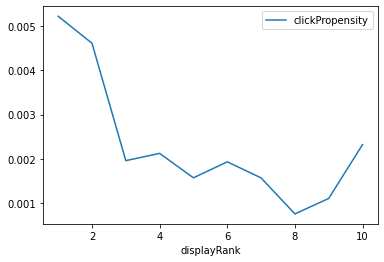

In [11]:

@interact(
    siteId=sorted(pdf1["siteId"].unique()),
    experience=sorted(pdf1["experience"].unique()),
    placementId=sorted(pdf1["placementId"].unique())
    
)
def calc_plot(siteId, experience, placementId):
    pdf2 = pdf1.loc[pdf1['experience'] == experience]
    pdf3 = pdf2.query(f"siteId == {siteId} and placementId == {placementId}")
    #pdf1["propensity_impression_weights"].plot.hist()
    #print(pdf1['propensity_impression_weights'].max())
    pdf3.plot.line(x="displayRank", y="clickPropensity")

        

In [45]:
pdf2=pdf[['siteId','placementId','displayRank','clickPropensity','experience']].drop_duplicates().sort_values(by='siteId')

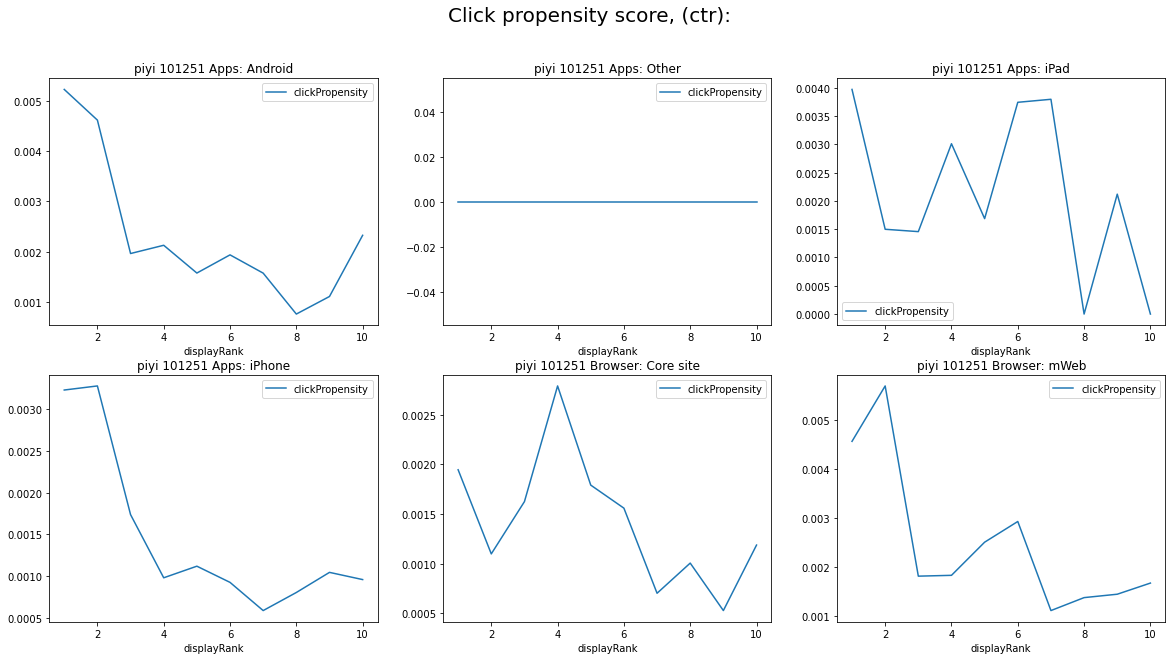

In [52]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
plt.suptitle("Click propensity score, (ctr):",fontsize=20)
pdf1[(pdf1["placementId"]==101251) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[0]) ].plot(ax=axes[0,0],x='displayRank',y='clickPropensity', title='piyi 101251 '+experience[0])
pdf1[(pdf1["placementId"]==101251)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[1])].plot(ax=axes[0,1],x='displayRank',y='clickPropensity', title='piyi 101251 ' +experience[1])
pdf1[(pdf1["placementId"]==101251)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[2])].plot(ax=axes[0,2],x='displayRank',y='clickPropensity', title='piyi 101251 ' +experience[2])
pdf1[(pdf1["placementId"]==101251) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[3]) ].plot(ax=axes[1,0],x='displayRank',y='clickPropensity', title='piyi 101251 ' +experience[3])
pdf1[(pdf1["placementId"]==101251)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[4])].plot(ax=axes[1,1],x='displayRank',y='clickPropensity', title='piyi 101251 ' +experience[4])
pdf1[(pdf1["placementId"]==101251)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[5])].plot(ax=axes[1,2],x='displayRank',y='clickPropensity', title='piyi 101251 ' +experience[5])

plt.show()

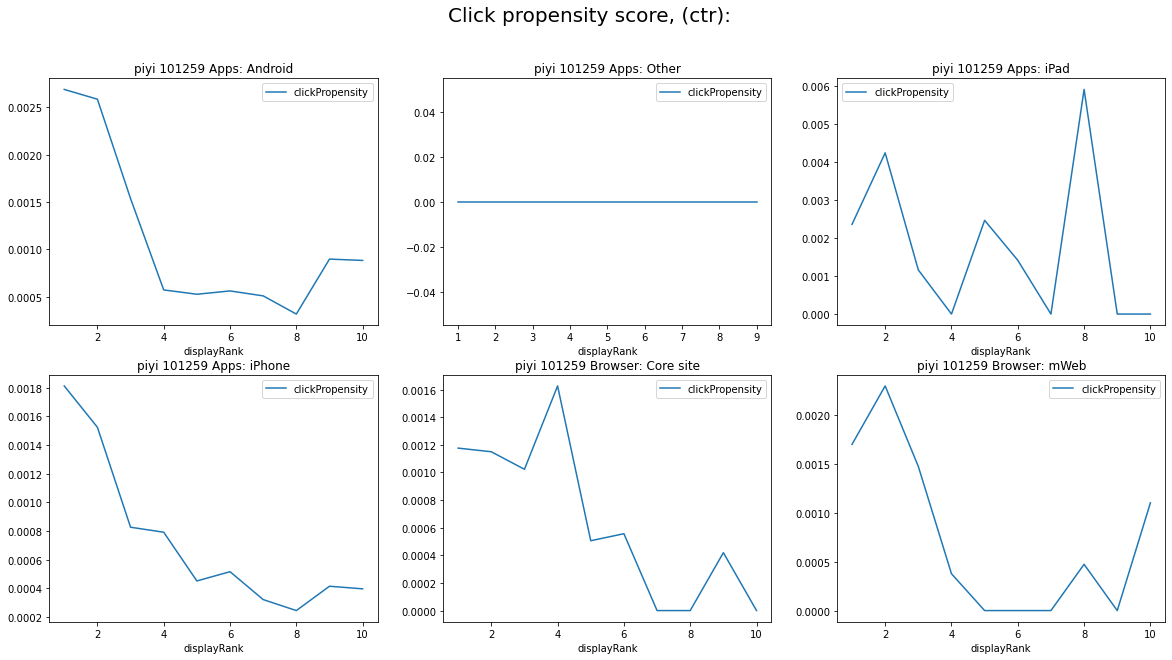

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
plt.suptitle("Click propensity score, (ctr):",fontsize=20)
pdf1[(pdf1["placementId"]==101259) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[0]) ].plot(ax=axes[0,0],x='displayRank',y='clickPropensity', title='piyi 101259 '+experience[0])
pdf1[(pdf1["placementId"]==101259)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[1])].plot(ax=axes[0,1],x='displayRank',y='clickPropensity', title='piyi 101259 ' +experience[1])
pdf1[(pdf1["placementId"]==101259)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[2])].plot(ax=axes[0,2],x='displayRank',y='clickPropensity', title='piyi 101259 ' +experience[2])
pdf1[(pdf1["placementId"]==101259) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[3]) ].plot(ax=axes[1,0],x='displayRank',y='clickPropensity', title='piyi 101259 ' +experience[3])
pdf1[(pdf1["placementId"]==101259)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[4])].plot(ax=axes[1,1],x='displayRank',y='clickPropensity', title='piyi 101259 ' +experience[4])
pdf1[(pdf1["placementId"]==101259)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[5])].plot(ax=axes[1,2],x='displayRank',y='clickPropensity', title='piyi 101259 ' +experience[5])

plt.show()

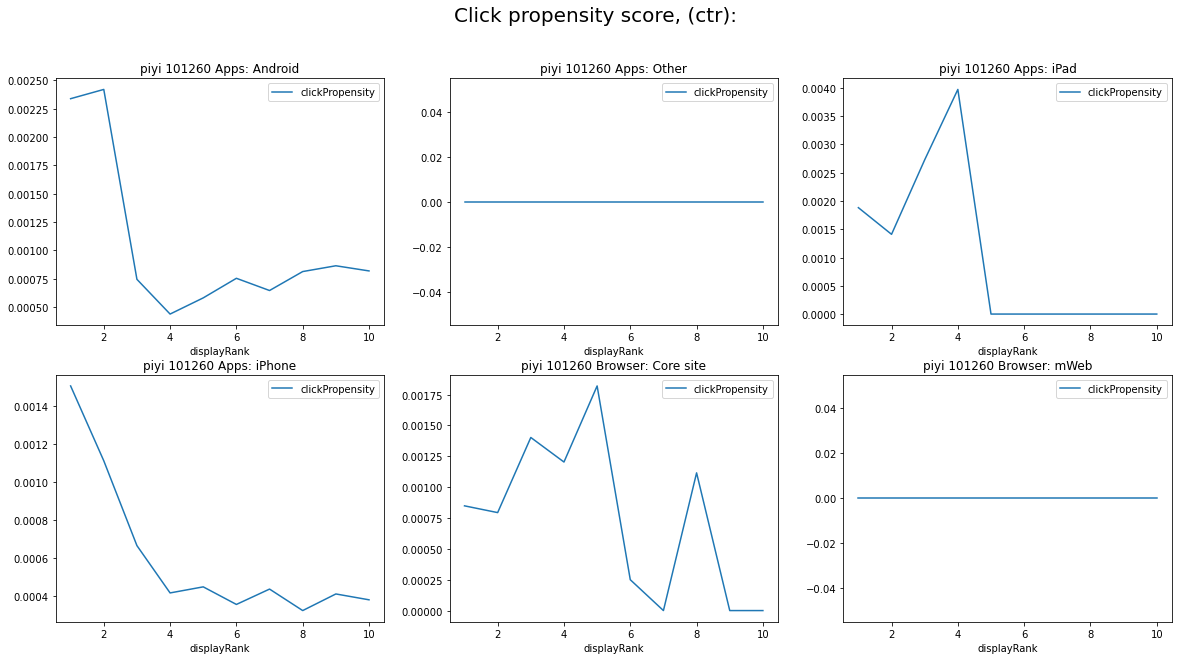

2023-01-16T11:08:27.628+0000: [Full GC (System.gc()) 2023-01-16T11:08:27.628+0000: [Tenured: 56975K->57173K(1398144K), 0.2625118 secs] 284153K->57173K(2027392K), [Metaspace: 129982K->129982K(1173504K)], 0.2626027 secs] [Times: user=0.23 sys=0.03, real=0.26 secs] 


In [57]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
plt.suptitle("Click propensity score, (ctr):",fontsize=20)
pdf1[(pdf1["placementId"]==101260) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[0]) ].plot(ax=axes[0,0],x='displayRank',y='clickPropensity', title='piyi 101260 '+experience[0])
pdf1[(pdf1["placementId"]==101260)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[1])].plot(ax=axes[0,1],x='displayRank',y='clickPropensity', title='piyi 101260 ' +experience[1])
pdf1[(pdf1["placementId"]==101260)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[2])].plot(ax=axes[0,2],x='displayRank',y='clickPropensity', title='piyi 101260 ' +experience[2])
pdf1[(pdf1["placementId"]==101260) & (pdf1["siteId"]==0)& (pdf1['experience'] == experience[3]) ].plot(ax=axes[1,0],x='displayRank',y='clickPropensity', title='piyi 101260 ' +experience[3])
pdf1[(pdf1["placementId"]==101260)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[4])].plot(ax=axes[1,1],x='displayRank',y='clickPropensity', title='piyi 101260 ' +experience[4])
pdf1[(pdf1["placementId"]==101260)&(pdf1["siteId"]==0)& (pdf1['experience'] == experience[5])].plot(ax=axes[1,2],x='displayRank',y='clickPropensity', title='piyi 101260 ' +experience[5])

plt.show()

In [ ]:
piyi=[101251, 101259, 101260] 

In [ ]:
clickPropensity=pdf[['siteId','placementId','displayRank','clickPropensity']].drop_duplicates().sort_values(by='siteId')

In [ ]:
clickPropensity[(clickPropensity["placementId"]==101251) & (clickPropensity["siteId"]==0) ].sort_values(by='displayRank')

In [ ]:
spark.sparkContext.stop()